In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yt
import yt.units as u
import sys
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

## Load the FLASH file

In [4]:
ds = yt.load("../../TDE_plot/multitidal_hdf5_plt_cnt_0100")
ds

yt : [INFO     ] 2021-01-17 22:52:02,863 Parameters: current_time              = 189076.38
yt : [INFO     ] 2021-01-17 22:52:02,864 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2021-01-17 22:52:02,871 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-01-17 22:52:02,873 Parameters: domain_right_edge         = [7.240177e+13 7.240177e+13 3.620088e+13]
yt : [INFO     ] 2021-01-17 22:52:02,875 Parameters: cosmological_simulation   = 0.0


multitidal_hdf5_plt_cnt_0100

In [5]:
edata = np.loadtxt('../../TDE_plot/m0.8_p17_b0.6_P110/extras.dat',
                   dtype='float64')
G = u.gravitational_constant
gmpt = G * edata[6] * u.g

odata = np.loadtxt('../../TDE_plot/m0.8_p17_b0.6_P110/pruned_sinks_evol.dat',
                   dtype='float64')

if odata[0, 14] > odata[1, 14]:
    part_tag_pt = odata[0, 0]
else:
    part_tag_pt = odata[1, 0]
odata_pt = odata[np.where(odata[:, 0] == part_tag_pt)[0]]
odata_ob = odata[np.where(odata[:, 0] != part_tag_pt)[0]]

ptvec = odata_pt[:, 2:8]
obvec = odata_ob[:, 2:8]
boundvec = obvec
time = odata_pt[:, 1]
tindex = abs(time - ds.current_time.v).argmin()


def _bhbound(field, data):
    pos = np.zeros(data['x'].shape, dtype='float64')
    vel2 = pos.copy()
    for i, ax in enumerate(['x', 'y', 'z']):
        pos += (data[ax] - ptvec[tindex, i] * u.cm)**2.
    for i, ax in enumerate(['velx', 'vely', 'velz']):
        vel2 += (data[ax] - ptvec[tindex, i + 3] * u.cm / u.s)**2.
    pot = -gmpt / np.sqrt(pos) + 0.5 * vel2
    return (pot)

def _tfallback(field, data):
    pot = data['bhbound']
    return (gmpt * np.pi / np.sqrt(2) / (-pot)**(3/2))


'''def _selfbound(field, data):
    vel2 = np.zeros(data['x'].shape, dtype='float64')
    V = [data["velx"], data["vely"], data["velz"]]
    for i, ax in enumerate(['velx', 'vely', 'velz']):
        vel2 += (data[ax] - boundvec[tindex, i + 3] * u.cm / u.s)**2.

    pot = 0.5 * data['gpot'] + 0.5 * vel2
    return (pot)'''


yt.add_field(("gas", "bhbound"),
             function=_bhbound,
             units="erg/g",
             take_log=False,
             force_override=True,
             sampling_type="cell")

'''yt.add_field(("gas", "selfbound"),
             function=_selfbound,
             units="erg/g",
             take_log=False,
             force_override=True,
             sampling_type="cell")'''

yt.add_field(("gas", "tfallback"),
             function=_tfallback,
             units="day",
             take_log=False,
             force_override=True,
             sampling_type="cell")

In [6]:
ds = yt.load("../../TDE_plot/multitidal_hdf5_plt_cnt_0100")

yt : [INFO     ] 2021-01-17 22:53:08,427 Parameters: current_time              = 189076.38
yt : [INFO     ] 2021-01-17 22:53:08,430 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2021-01-17 22:53:08,432 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-01-17 22:53:08,436 Parameters: domain_right_edge         = [7.240177e+13 7.240177e+13 3.620088e+13]
yt : [INFO     ] 2021-01-17 22:53:08,442 Parameters: cosmological_simulation   = 0.0


In [7]:
# Rotate image/mask


def rotate_image(image, angle, method='spline', order=5, reshape=False, cval=0.0):
    '''Rotate the image of Stack object.
    Parameters:
        angle (float): rotation angle in radian, counterclockwise.
        method (str): interpolation method. Use 'lanczos', 'spline', 'cubic', 
            'bicubic', 'nearest' or 'bilinear'.
        order (int): the order of spline interpolation (within 0-5) or Lanczos interpolation (>0).
        reshape (bool): if True, the output shape is adapted so that the rorated image 
            is contained completely in the output array.
        cval (scalar): value to fill the edges. Default is NaN.
    Returns:
        rotate_image: ndarray.
    '''
    if method == 'lanczos':
        try:
            from galsim import degrees, Angle
            from galsim.interpolant import Lanczos
            from galsim import Image, InterpolatedImage
            from galsim.fitswcs import AstropyWCS
        except:
            raise ImportError(
                '# Import `galsim` failed! Please check if `galsim` is installed!')
        # Begin rotation
        assert (order > 0) and isinstance(order, int), 'order of ' + \
            method + ' must be positive interger.'
        pixel_scale = 1
        galimg = InterpolatedImage(Image(image, dtype=float),
                                   scale=pixel_scale, x_interpolant=Lanczos(order))
        galimg = galimg.rotate(Angle(angle, unit=degrees))
        ny, nx = image.shape
        result = galimg.drawImage(scale=pixel_scale, nx=nx, ny=ny)
        return result.array
    elif method == 'spline':
        from scipy.ndimage.interpolation import rotate as rt
        assert 0 < order <= 5 and isinstance(
            order, int), 'order of ' + method + ' must be within 0-5.'
        result = rt(image, -angle, order=order, mode='constant',
                    cval=cval, reshape=reshape)
        return result
    elif method in ['bicubic', 'nearest', 'cubic', 'bilinear']:
        '''raise Warning(
            "Cautious! Don't use ['bicubic', 'nearest', 'cubic', 'bilinear'] methods! They don't conserve the total flux!")'''
        try:
            from scipy.misc import imrotate
        except:
            raise ImportError(
                '# Import `scipy.misc.imrotate` failed! This function may no longer be included in scipy!')
        result = imrotate(image, angle, interp=method)
        return result
    else:
        raise ValueError("# Not supported interpolation method. Use 'lanczos', 'spline', 'cubic', \
                            'bicubic', 'nearest', 'bilinear'.")



In [8]:
da = ds.all_data()
angle = -40

In [35]:
N = 5000
width = 300
da = ds.all_data()
proj_tot = yt.ProjectionPlot(ds, 
                             'z', 
                             'dens', 
                             method='sum',
                             data_source=da).data_source.to_frb((width, 'Rsun'), N)
proj_lgdens_tot = np.log10(np.array(proj_tot['dens']))
kernel = Gaussian2DKernel(x_stddev=2)
proj_dens_tot_blur = 10**convolve(proj_lgdens_tot, kernel)

yt : [INFO     ] 2021-01-17 23:22:49,317 Projection completed
yt : [INFO     ] 2021-01-17 23:22:49,318 xlim = 0.000000 72401770000000.000000
yt : [INFO     ] 2021-01-17 23:22:49,320 ylim = 0.000000 72401770000000.000000
yt : [INFO     ] 2021-01-17 23:22:49,323 xlim = 0.000000 72401770000000.000000
yt : [INFO     ] 2021-01-17 23:22:49,325 ylim = 0.000000 72401770000000.000000
yt : [INFO     ] 2021-01-17 23:22:49,328 Making a fixed resolution buffer of (('flash', 'dens')) 800 by 800
yt : [INFO     ] 2021-01-17 23:22:49,632 Making a fixed resolution buffer of (dens) 5000 by 5000


In [51]:
bins = np.logspace(np.log10(da['dens'].max()) - 1, np.log10(da['dens'].min()) + 4, 1000)
Mtot = da['cell_mass'].sum()
for b in bins:
    cut = da.include_above('dens', b)
    M = cut['cell_mass'].sum()
    if M >= 0.996 * Mtot:
        region = da.include_above('dens', b)
        print(b, M, M/Mtot)
        break

5.205972300410691e-06 1.612019680797484e+33 g 0.9960011540325304 dimensionless


In [52]:
proj_tot = yt.ProjectionPlot(ds, 
                             'z', 
                             'bhbound', 
                             data_source=da, 
                             weight_field='dens').data_source.to_frb((width, 'Rsun'), N)
proj_bhbound_tot = np.array(proj_tot['bhbound'])

proj_bhbound_blur = proj_bhbound_tot.copy()
proj_bhbound_blur[proj_dens_tot_blur < b] = -1e25

yt : [INFO     ] 2021-01-17 23:41:43,636 Projection completed
yt : [INFO     ] 2021-01-17 23:41:43,640 xlim = 0.000000 72401770000000.000000
yt : [INFO     ] 2021-01-17 23:41:43,642 ylim = 0.000000 72401770000000.000000
yt : [INFO     ] 2021-01-17 23:41:43,645 xlim = 0.000000 72401770000000.000000
yt : [INFO     ] 2021-01-17 23:41:43,654 ylim = 0.000000 72401770000000.000000
yt : [INFO     ] 2021-01-17 23:41:43,766 Making a fixed resolution buffer of (('gas', 'bhbound')) 800 by 800
yt : [INFO     ] 2021-01-17 23:41:44,055 Making a fixed resolution buffer of (bhbound) 5000 by 5000


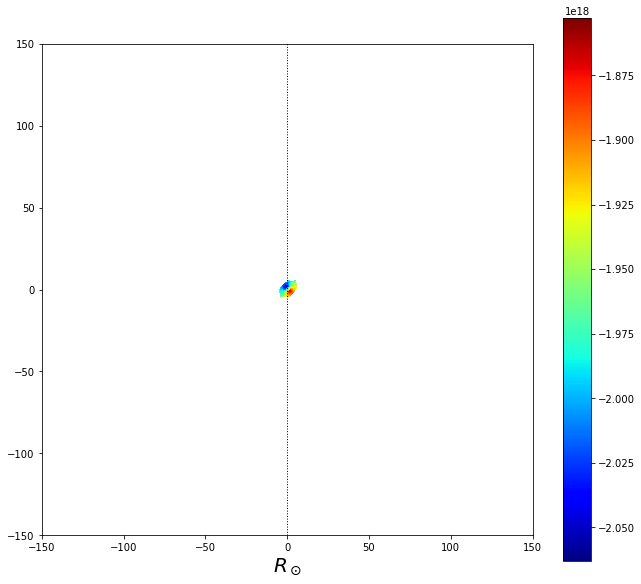

In [53]:
Max = proj_bhbound_blur[proj_bhbound_blur > -1e25].max()
Min = proj_bhbound_blur[proj_bhbound_blur > -1e25].min()

proj_bhbound_rot_blur = rotate_image(proj_bhbound_blur, angle, method='spline', order=5)
proj_bhbound_tot_rot = rotate_image(proj_bhbound_tot, angle, method='spline', order=5)
proj_bhbound_tot_rot[proj_bhbound_rot_blur > Max] = np.nan
proj_bhbound_tot_rot[proj_bhbound_rot_blur < Min] = np.nan
plt.figure(figsize=(11, 10))
for i in range(N):
    for j in range(N):
        if (i-N/2)**2+(j-N/2)**2 >= N**2//4:
            proj_bhbound_tot_rot[i][j] = np.nan

plt.imshow(proj_bhbound_tot_rot, origin='lower', cmap='jet', extent=[-width//2, width//2, -width//2, width//2])
plt.axvline(color='k', linewidth=1, linestyle=':')
plt.xlabel(r'$R_\odot$', fontsize=20)
plt.colorbar()
#plt.clim([-1, 1])
#plt.xlim([4800, 5200])
#plt.ylim([4800, 5200])
plt.show()

In [55]:
raw, raw50, raw114 = np.load('m1.0_p10_b0.8.npz'), np.load(
    'm1.0_p10_b0.8_P50.npz'), np.load('m1.0_p10_b0.8_P110.npz')

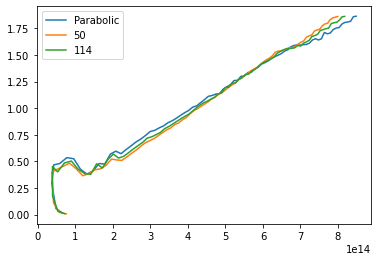

In [60]:
plt.plot(raw['x'], raw['y'], label='Parabolic')
plt.plot(raw50['x'], raw50['y'], label='50')
plt.plot(raw114['x'], raw114['y'], label='114')
plt.legend()

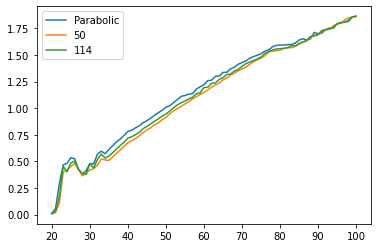

In [61]:
plt.plot(np.arange(len((raw['x']))) + 20, raw['y'], label='Parabolic')
plt.plot(np.arange(len((raw['x']))) + 20, raw50['y'], label='50')
plt.plot(np.arange(len((raw['x']))) + 20, raw114['y'], label='114')
plt.legend()